<a href="https://colab.research.google.com/github/Lisankk/Dirisl_Phase2_PJT/blob/Ito_branch/%E3%82%AF%E3%83%BC%E3%83%9D%E3%83%B3%E3%81%82%E3%82%8A%E3%83%A2%E3%83%87%E3%83%AB_(CV%E3%81%82%E3%82%8A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import scipy as sp
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
#csvファイルの読み込み
df = pd.read_csv('/content/drive/MyDrive/abtest_results_for_coupon_sending.csv')
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,area_classification,newbie,channel,segment,visit,conversion,spend
0,男性,6,32908,1,1,地方,1,ウェブ,送付なし,0,0,0
1,男性,9,67583,1,0,地方,1,ウェブ,送付あり,0,0,0
2,女性,9,67507,1,1,地方,1,スマートフォン,送付あり,0,0,0
3,男性,2,10164,0,1,都会,0,ウェブ,送付あり,1,0,0
4,女性,4,24142,0,1,地方,1,複数,送付なし,0,0,0


In [29]:
df["sex"] = df["sex"].map({"男性": 0, "女性": 1})
df["area_classification"] = df["area_classification"].map({"都会": 0, "郊外": 1, "地方": 2})
df["segment"] = df["segment"].map({"送付あり": 0, "送付なし": 1})
df["channel"] = df["channel"].map({"ウェブ": 0, "スマートフォン": 1, "複数": 2})

In [32]:
df_RF = df[["recency", "history", "area_classification", "newbie", "segment", "visit"]]
df_RF

,recency,history,area_classification,newbie,segment,visit
0,6,32908,2,1,1,0
1,9,67583,2,1,0,0
2,9,67507,2,1,0,0
3,2,10164,0,0,0,1
4,4,24142,2,1,1,0
...,...,...,...,...,...,...
42608,7,8646,0,0,0,1
42609,10,10554,0,0,0,1
42610,5,3890,0,1,0,0
42611,6,2999,0,1,0,1


**ランダムフォレストの実装に当たってクーポンありとなしのグループに分ける**

In [17]:
df_RF_YesKoupon = df_RF[df_RF["segment"] == 0]
df_RF_NoKoupon = df_RF[df_RF["segment"] == 1]

In [18]:
df_RF_YesKoupon = df_RF_YesKoupon.drop("segment", axis = 1)
df_RF_NoKoupon = df_RF_NoKoupon.drop("segment", axis = 1)



---
以下より、同じくクーポンありモデルについて、交差検証ありのRandom Forestの実装を進めていく。


**交差検証の実装**

In [34]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42)

# 説明変数と目的変数の定義
X = df_RF_YesKoupon[["recency", "history", "area_classification", "newbie"]]
y = df_RF_YesKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross validation scores: {scores}')

Cross validation scores: [0.92247596 0.92618647 0.92699776 0.92581459 0.92491268]


**oof算出処理の実装**

In [35]:
# oof予測値を格納する配列
oof_predictions = np.zeros(X.shape[0])

# クロスバリデーションの実行
for train_index, val_index in kf.split(X):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]

  # モデル学習
  model.fit(X_train, y_train)

  # oof予測値の保存
  oof_predictions[val_index] = model.predict_proba(X_val)[:, 1]

# OOFスコア（AUCを使用）を計算
oof_score = roc_auc_score(y, oof_predictions)
print(f'OOF AUC Score: {oof_score}')

OOF AUC Score: 0.9252794089980265


**評価**

In [36]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train, X_test, t_train, t_test = train_test_split(
    df_RF_YesKoupon[["recency", "history", "area_classification", "newbie"]],
    df_RF_YesKoupon["visit"],
    test_size=0.3,
    random_state=0
)

AUC (CVあり): 0.9237551155695246
正解率 (CVあり): 83.15%
適合率 (CVあり): 87.04%
再現率 (CVあり): 85.89%
F1 (CVあり): 86.46%


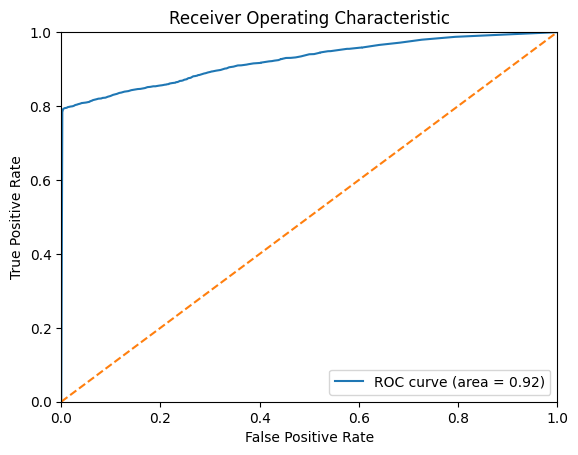

In [37]:
# 訓練データ全体でモデルを再訓練
model.fit(X_train, t_train)

# テストデータでの予測
test_predictions = model.predict_proba(X_test)[:, 1]

# テストデータでのAUC評価
test_auc = roc_auc_score(t_test, test_predictions)
print(f'AUC (CVあり): {test_auc}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test)
score_cv = accuracy_score(t_test, test_preds_binary)
precision_cv = precision_score(t_test, test_preds_binary)
recall_cv = recall_score(t_test, test_preds_binary)
f1_cv = f1_score(t_test, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test, test_predictions)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

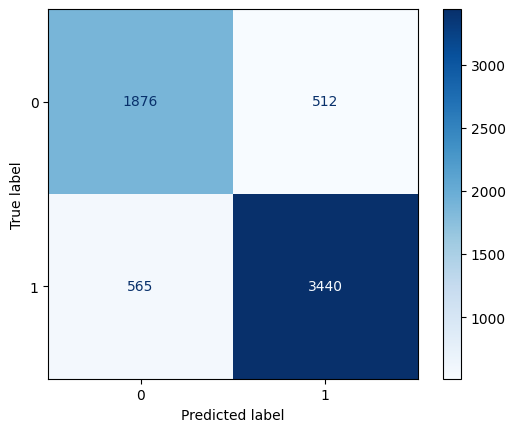

In [39]:
# 混同行列
cm = confusion_matrix(t_test, test_preds_binary)
cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmp.plot(cmap=plt.cm.Blues)